In [1]:
import numpy as np
import multiprocessing as mp
from multiprocessing import Pool, cpu_count, Value
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA, KernelPCA
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.cluster import KMeans
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from skopt import BayesSearchCV
from xgboost import XGBClassifier
import os.path
import cv2
import matplotlib.pyplot as plt
from ctypes import *
import sys
import threading
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from read_image import read_images

In [2]:
def readLabels(label_dir, label_name):
    with open(os.path.join(label_dir, label_name), "r") as f:
        content = f.read()
    
    label = content.split(",")
    label = map(lambda x: int(x), label)
    return np.array(list(label))

def run(fnc, images, data):
    images.append(None)
    with Pool(cpu_count()) as pool:
        images[0] = pool.map(fnc, data)
        

In [3]:
SO_DIRPATH = "../libs/"
TRAIN_IMAGES_DIR = "../../mnist/images/train_images" 
TEST_IMAGES_DIR = "../../mnist/images/test_images"
TRAIN_LABELS_DIR = "../../mnist/labels/train_labels"
TEST_LABELS_DIR =  "../../mnist/labels/test_labels"
IMAGE_NAME = "number{}.png"
LABELS_NAME = "labels.txt"
LOOP_LABELS_NAME = "loops.txt"
N_TRAIN = 60000
N_TEST = 10000

In [4]:
number_label_train = readLabels(TRAIN_LABELS_DIR, LABELS_NAME)[:N_TRAIN]
number_label_test = readLabels(TEST_LABELS_DIR, LABELS_NAME)[:N_TRAIN]

In [5]:
images = []
data = [os.path.join(TRAIN_IMAGES_DIR, IMAGE_NAME.format(i + 1)) for i in range(N_TRAIN)]
t = threading.Thread(target = run, args=(read_images, images, data,  ))
t.start()
t.join()

In [6]:
X_train = np.array(images[0])
y_train = np.array(number_label_train)

In [7]:
images = []
data = [os.path.join(TEST_IMAGES_DIR, IMAGE_NAME.format(i + 1)) for i in range(N_TEST)]
t = threading.Thread(target = run, args=(read_images, images, data,  ))
t.start()
t.join()

In [9]:
X_test = np.array(images[0])
y_test = np.array(number_label_test)

In [10]:
np.shape(X_train)

(60000, 28, 28)

In [13]:
np.shape(X_test)

(10000, 28, 28)

# Preprocess

In [10]:
X_train = np.array(X_train).reshape(60000, 28, 28, 1)

In [20]:
datagen = ImageDataGenerator(
    rotation_range=45, 
    width_shift_range=1, 
    height_shift_range=1,
)

it = datagen.flow(X_train, y_train)

ValueError: `x` (images tensor) and `y` (labels) should have the same length. Found: x.shape = (60000, 28, 28, 1), y.shape = (180000,)

In [12]:
X_augmented_with_loop = []
y_augmented = []
n_batch = 3 * N_TRAIN // 32
batch = next(it, None)
for i in range(n_batch):
    imgs, labels = batch
    for i in range(len(imgs)):
        X_augmented_with_loop.append(imgs[i].reshape(-1))
        y_augmented.append(labels[i])
    batch = next(it, None)

In [13]:
X_train_final = X_augmented_with_loop
y_train = y_augmented

In [11]:
X_train_final = X_train.reshape(60000, 784)

In [14]:
X_test_final = X_test.reshape(10000, 784)

# Model Training

## 1. KNN Classifier

In [7]:
knn_clf = KNeighborsClassifier(n_neighbors=4, weights="distance")

## 2. XGB

In [21]:
xgb_clf = XGBClassifier(**{'gamma': 1.25,
 'learning_rate': 0.2,
 'max_depth': 9,
 'reg_lambda': 10,
 'scale_pos_weight': 5})

# Pipeline with KMeans

In [32]:
pipeline = Pipeline([
    ("kmeans", KMeans()), 
    ("knn_clf", knn_clf), 
])

# Optimization

In [21]:
param_grid = {
    "n_neighbors": [10, 20, 30], 
    "weights": ["distance"], 
}

In [22]:
opt = BayesSearchCV(
    KNeighborsClassifier(),
    param_grid,
    n_iter=32,
    cv=3, 
    verbose=10,
)


In [28]:
opt.fit(X_train_final, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3; 1/1] START n_neighbors=20, weights=distance............................


KeyboardInterrupt: 

In [38]:
param_grid = {
    "kmeans__n_clusters": [93, 96, 99],
}

In [39]:
opt = BayesSearchCV(
    pipeline,
    param_grid,
    n_iter=32,
    cv=3, 
    verbose=10,
)


In [40]:
opt.fit(X_train_final, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3; 1/1] START kmeans__n_clusters=93.......................................
[CV 1/3; 1/1] END ........kmeans__n_clusters=93;, score=0.951 total time= 3.6min
[CV 2/3; 1/1] START kmeans__n_clusters=93.......................................


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 


KeyboardInterrupt: 

In [18]:
param_grid = {
    "max_depth": [10],
    "learning_rate": [0.2],
    "gamma": [1.5, 1.75, 2],
    "reg_lambda": [10],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}

In [19]:
opt = BayesSearchCV(
    XGBClassifier(),
    param_grid,
    n_iter=32,
    cv=3, 
    verbose=10,
)

In [20]:
opt.fit(X_train_final, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3; 1/1] START colsample_bytree=0.5, gamma=1.75, learning_rate=0.2, max_depth=10, reg_lambda=10, subsample=0.8
[CV 1/3; 1/1] END colsample_bytree=0.5, gamma=1.75, learning_rate=0.2, max_depth=10, reg_lambda=10, subsample=0.8;, score=0.968 total time= 6.5min
[CV 2/3; 1/1] START colsample_bytree=0.5, gamma=1.75, learning_rate=0.2, max_depth=10, reg_lambda=10, subsample=0.8


KeyboardInterrupt: 

# Evaluation

In [10]:
cross_val_score(xgb_clf, X_train_final, y_train, cv=3, scoring="accuracy", verbose=10, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 62.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 62.1min finished


array([0.96795, 0.9653 , 0.96945])

In [11]:
y_train_predict = cross_val_predict(xgb_clf, X_train_final, y_train, cv=3, verbose=10, n_jobs=3)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed: 29.0min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed: 29.0min finished


In [12]:
conf_mx = confusion_matrix(y_train, y_train_predict)

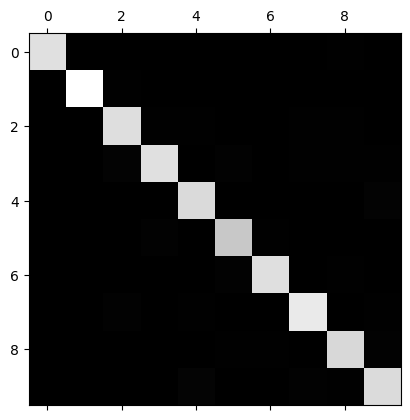

In [13]:
plt.matshow(conf_mx, cmap="gray")

In [14]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

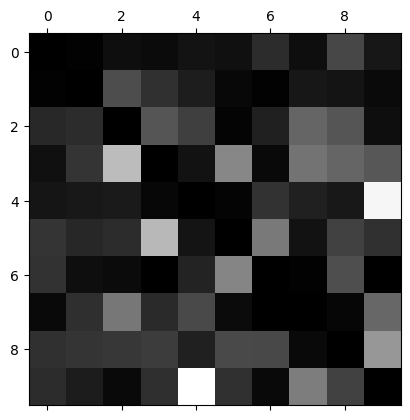

In [15]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

In [ ]:
knn_clf.score(X_test, y_test)

In [ ]:
y_predict = knn_clf.predict(X_test_final)

In [ ]:
conf_mx = confusion_matrix(y_test, y_predict)
plt.matshow(conf_mx, cmap="gray")

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

In [37]:
type(y_test)

numpy.ndarray

In [20]:
X_aa = X_train_final[(y_train == 1) & (y_train_predict == 1)]
X_ab = X_train_final[(y_train == 3) & (y_train_predict == 2)]

In [21]:
np.shape(X_ab)

(82, 784)

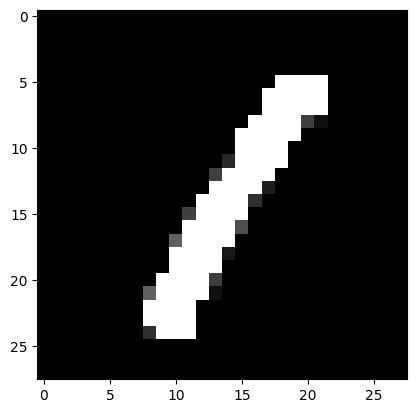

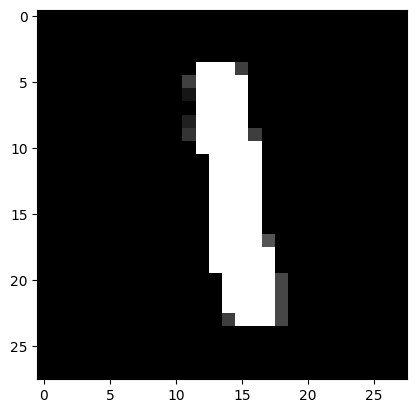

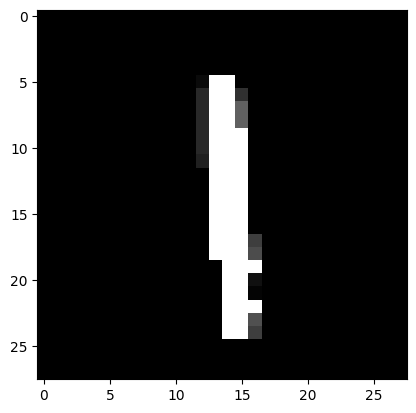

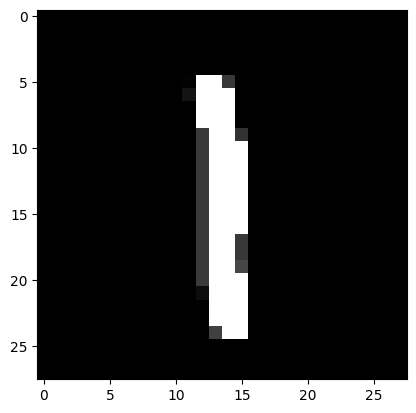

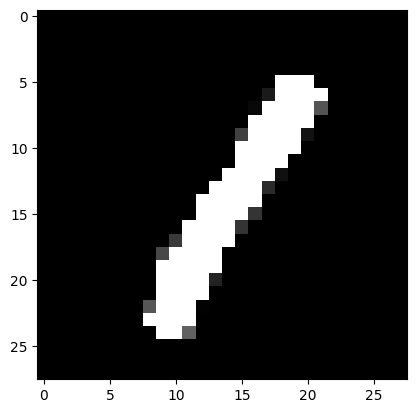

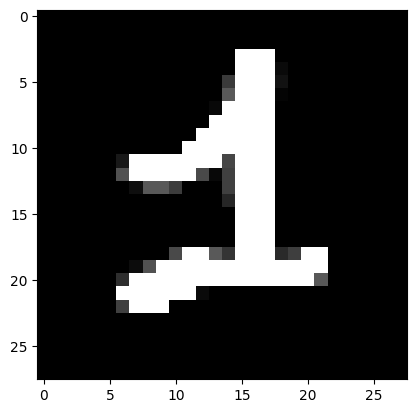

KeyboardInterrupt: 

In [22]:
for i in range(100):
    plt.imshow(X_aa[i].reshape(28, 28), cmap="gray")
    plt.show()

In [ ]:
for i in range(len(X_ab)):
    plt.imshow(X_ab[i].reshape(28, 28), cmap="gray")
    plt.show()

In [19]:
X_ab[6]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   